In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
os.chdir('../')

In [3]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_volume


In [7]:
# connect to the db
# config_file = "config/config_eagle.yaml"
config_file = "/projects/rlmolecule/jlaw/crystal_vol/opt_cvol_mcts100_debug/run.yaml"
run_config = RunConfig(config_file)
engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()

In [23]:
def load_games_played(session, run_id):
#     print("Loading games")
    df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

    df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('time_hours')
    df_games = df
    df_games.reset_index(drop=True, inplace=True)
#     print(df_games.tail(3))
    return df_games


def load_rewards(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
    # df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('reward', ascending=False)
    df_rew = df
#     print(df_rew.tail(3))
    return df_rew


def load_states(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(StateStore).filter_by(run_id=run_id).statement, session.bind)
    return df

def get_state_for_rew(digest, df_state):
    return df_state[df_state['digest'] == digest]


# def write_best_crystals():
#     df_rew = load_rewards

In [6]:
def plot_reward_train_curves(df, log, out_dir, title=""):
    fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(3, 2.75), dpi=150)
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)
    axs[1].legend(
        loc='upper right', ncol=2,
        borderpad=0, borderaxespad=0.1,
        bbox_to_anchor=(1.1, 1.2))

    # axs[0].set_ylim([0, 250])
#     axs[0].set_ylim([0, 1.0])
    #axs[1].set_ylim([0, .7])
    #axs[1].set_xlim([-.01, 4])
    axs[0].set_ylabel('Reward')
    axs[1].set_ylabel('Policy Training')
    axs[1].set_xlabel('Time (hours)')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.suptitle(title, y=1.0)

    out_file = f"{out_dir}/training-and-reward.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

# Compare Experiment Results

In [6]:
from IPython.display import SVG, display

In [9]:
exp_name = "crystal_vol"
run_id = run_config.run_id
print(run_id)

opt_cvol_mcts100_debug


In [20]:
def main_results(run_id, session):
    working_dir = f"/projects/rlmolecule/jlaw/{exp_name}/{run_id}"
    # load the games played
    df_games = load_games_played(session, run_id)
    print(df_games.head())

    log_file = f"{working_dir}/policy_checkpoints/log.csv"
    print(f"Reading {log_file}")
    log = pd.read_csv(log_file)
    log['time'] = pd.to_datetime(log.time)
    log['time'] = pd.to_datetime(log.time)
    log['time_hours'] = (log.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
#     print(log.tail(3))

    # now plot the results
    out_dir = f"{working_dir}/viz"
    plot_reward_train_curves(df_games, log, out_dir, title=run_id)

    # and write POSCAR files for the best molecules
    df_rew = load_rewards(session, run_id)
    print(df_rew.head())
    return df_rew

                                     id                  run_id  \
0  979c1665-1239-4e14-9712-3d0ac889d515  opt_cvol_mcts100_debug   
1  9b9922cb-6096-4490-b959-85f40a54a315  opt_cvol_mcts100_debug   
2  1b60a1df-c1f0-4f9d-a055-7b2778a8b4d1  opt_cvol_mcts100_debug   
3  453927b9-467e-4cca-8c63-47565cd51b4c  opt_cvol_mcts100_debug   
4  51f42ee7-6287-4644-a16e-c1c242013cec  opt_cvol_mcts100_debug   

                        time  raw_reward  scaled_reward  \
0 2021-07-09 13:40:12.592983    0.355227            0.0   
1 2021-07-09 13:40:13.503813    0.000000            1.0   
2 2021-07-09 13:40:13.627252    0.051935            1.0   
3 2021-07-09 13:40:16.262390    0.321801            1.0   
4 2021-07-09 13:40:28.383165    0.304803            0.0   

                                   search_statistics  \
0  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
1  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
2  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
3  [[4f27ce5de30b5

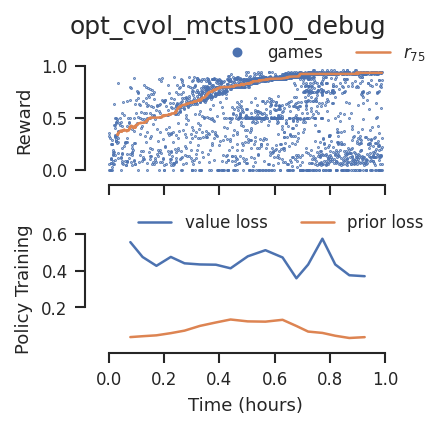

                                                  digest                 hash  \
83992  0433e150332f0c0d540d7b5c929ac2e446c304361cb257...  9118850087464527793   
86392  15a6521e61ba9fc4f26771501d4825e2d3ab7400c40d2f...  7214899612293632996   
90733  2836bb79d8b239c4e1e37b1320664c027770881e11c5b7...  8096305503359376100   
80754  d5fdfe5f0cc71e07996872417bb2d639b80780ef9c8ae9...  8802997818691025470   
83406  489273c22cf17f170741971f520160daa86b36d9632e50...  8802997818691025470   

                       run_id                       time   reward  \
83992  opt_cvol_mcts100_debug 2021-07-09 14:27:24.626318  0.95487   
86392  opt_cvol_mcts100_debug 2021-07-09 14:28:24.960980  0.95487   
90733  opt_cvol_mcts100_debug 2021-07-09 14:30:59.779443  0.95487   
80754  opt_cvol_mcts100_debug 2021-07-09 14:24:29.741205  0.95487   
83406  opt_cvol_mcts100_debug 2021-07-09 14:26:31.988250  0.95487   

                                                    data  
83992  {'terminal': True, 'conducting_i

In [21]:
# initial results
for run_id in ["opt_cvol_mcts100_debug"]:
    main_results(run_id, session)

In [19]:
# initial results
for run_id in ["opt_cvol_mcts100_debug"]:
    df_rew = main_results(run_id, session)

                                     id                  run_id  \
0  979c1665-1239-4e14-9712-3d0ac889d515  opt_cvol_mcts100_debug   
1  9b9922cb-6096-4490-b959-85f40a54a315  opt_cvol_mcts100_debug   
2  1b60a1df-c1f0-4f9d-a055-7b2778a8b4d1  opt_cvol_mcts100_debug   
3  453927b9-467e-4cca-8c63-47565cd51b4c  opt_cvol_mcts100_debug   
4  51f42ee7-6287-4644-a16e-c1c242013cec  opt_cvol_mcts100_debug   

                        time  raw_reward  scaled_reward  \
0 2021-07-09 13:40:12.592983    0.355227            0.0   
1 2021-07-09 13:40:13.503813    0.000000            1.0   
2 2021-07-09 13:40:13.627252    0.051935            1.0   
3 2021-07-09 13:40:16.262390    0.321801            1.0   
4 2021-07-09 13:40:28.383165    0.304803            0.0   

                                   search_statistics  \
0  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
1  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
2  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
3  [[4f27ce5de30b5

In [22]:
df_rew.head()

,digest,hash,run_id,time,reward,data
80893,cb3138350dda964f0cc9b252cecf6b44c05b35dbd9359d...,7000003398653280363,opt_cvol_mcts100_debug,2021-07-09 14:24:35.524485,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
90731,2836bb79d8b239c4e1e37b1320664c027770881e11c5b7...,8096305503359376100,opt_cvol_mcts100_debug,2021-07-09 14:30:59.779443,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
37686,4de8009af1dd428527a7be86463a6065f4ce887315b3e4...,8802997818691025470,opt_cvol_mcts100_debug,2021-07-09 14:02:47.286220,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
83985,0433e150332f0c0d540d7b5c929ac2e446c304361cb257...,9118850087464527793,opt_cvol_mcts100_debug,2021-07-09 14:27:24.626318,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."
94824,c1220764ef90087cba352cb25e3f8eb74a590d1ba71971...,7214899612293632996,opt_cvol_mcts100_debug,2021-07-09 14:33:35.249387,0.95487,"{'terminal': True, 'conducting_ion_vol': 5361...."


In [24]:
df_state = load_states(session, run_id)
df_state.head()

,digest,hash,run_id,time,state,policy_inputs
0,00017451a6d2ee341abba0c90a726aa55b1d3bf9e83cb1...,1860543008379754047,opt_cvol_mcts100_debug,2021-07-09 14:24:21.074756,b'x\x9ck`\x99:\x93\x01\x02z\x14\x8arr\xf3sR\x9...,b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...
1,00017befe98f529a68b3f78c120df4985a52e04276b049...,1152587651522639454,opt_cvol_mcts100_debug,2021-07-09 14:11:57.790131,b'x\x9ck`\x99\xda\xca\x00\x01=\nE9\xb9\xf99\xa...,b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...
2,0003779463c83c6d0553d8fc71df19f17e0e9c52ff93fb...,1452531973254359977,opt_cvol_mcts100_debug,2021-07-09 14:14:51.228796,"b""x\x9ck`\x99Z\xc9\x00\x01=\nE9\xb9\xf99\xa9\x...",b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...
3,00046eb526b902bf42504fee7d1e0938cdef39ff120ec7...,8034749085327161817,opt_cvol_mcts100_debug,2021-07-09 13:49:11.506833,b'x\x9ck`\x99:\x87\x01\x02z\x14\x8arr\xf3sR\x9...,b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...
4,0004efb9cee4cd0b56b315d2c982dbf6276fc9e6351806...,3491941185293113612,opt_cvol_mcts100_debug,2021-07-09 14:11:05.650308,b'x\x9ck`\x99Z\xc5\x00\x01=\nE9\xb9\xf99\xa9\x...,b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...


In [94]:
top_rew = df_rew[df_rew['reward'] > 0.9]

In [38]:
import pickle
import zlib

In [95]:
best_states = []
for i, (digest, hash_str, run_id, time, rew, data) in top_rew.iterrows():
#     if digest in df_state['digest']:
    states = get_state_for_rew(digest, df_state)
    for state_str in states['state']:
#         state_str = get_state_for_rew(digest, df_state)['state'].values[0]
# #     if hash_str in df_state['hash']:
# #         state_str = df_state[df_state['hash'] == hash_str]['state'].values[0]
        crystal = pickle.loads(zlib.decompress(state_str))
        best_states.append(crystal)
len(best_states)

585

In [117]:
best_decorations = set([str(c) + '|1' if '|1' not in str(c) else str(c) for c in best_states])
len(best_decorations)

86

In [119]:
from examples.crystal_volume import optimize_crystal_volume as ocv
from rlmolecule.crystal.crystal_state import CrystalState
from tqdm.notebook import tqdm

In [115]:
def write_decorated_structure(decorated_str, out_dir):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = ocv.structures[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}

    # Compute the volume of the conducting ions.
    conducting_ion_vol, total_vol = ocv.compute_structure_vol(decorated_structure)
    frac_conducting_ion_vol = conducting_ion_vol / total_vol if total_vol != 0 else 0
#     print(conducting_ion_vol, total_vol, frac_conducting_ion_vol)
    out_file = f"{out_dir}/POSCAR_{decorated_str.replace('|','-')}"
    print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return [conducting_ion_vol, total_vol, frac_conducting_ion_vol]

In [120]:
# now write each of these to a file
out_dir = f"outputs/{run_id}-0_9"
os.makedirs(out_dir, exist_ok=True)
volume_stats = {}
for decorated_str in tqdm(best_decorations):
    vol_stats = write_decorated_structure(decorated_str, out_dir)
    volume_stats[decorated_str] = [decorated_str.split('|')[-2]] + vol_stats

  0%|          | 0/86 [00:00<?, ?it/s]

K2O1|_1_2|monoclinic|POSCAR_sg12_icsd_089837|1 K2O1 _1_2|monoclinic|POSCAR_sg12_icsd_089837
writing outputs/opt_cvol_mcts100_debug-0_9/POSCAR_K2O1-_1_2-monoclinic-POSCAR_sg12_icsd_089837-1
K2S1|_1_2|cubic|POSCAR_sg227_icsd_055488|1 K2S1 _1_2|cubic|POSCAR_sg227_icsd_055488
writing outputs/opt_cvol_mcts100_debug-0_9/POSCAR_K2S1-_1_2-cubic-POSCAR_sg227_icsd_055488-1
Li3P1|_1_3|monoclinic|POSCAR_sg14_icsd_413919|1 Li3P1 _1_3|monoclinic|POSCAR_sg14_icsd_413919
writing outputs/opt_cvol_mcts100_debug-0_9/POSCAR_Li3P1-_1_3-monoclinic-POSCAR_sg14_icsd_413919-1
Na2O1|_1_2|monoclinic|POSCAR_sg12_icsd_089837|1 Na2O1 _1_2|monoclinic|POSCAR_sg12_icsd_089837
writing outputs/opt_cvol_mcts100_debug-0_9/POSCAR_Na2O1-_1_2-monoclinic-POSCAR_sg12_icsd_089837-1
K3P1|_1_3|monoclinic|POSCAR_sg14_icsd_413919|1 K3P1 _1_3|monoclinic|POSCAR_sg14_icsd_413919
writing outputs/opt_cvol_mcts100_debug-0_9/POSCAR_K3P1-_1_3-monoclinic-POSCAR_sg14_icsd_413919-1
Na2O1|_1_2|cubic|POSCAR_sg230_icsd_170477|1 Na2O1 _1_2|cubic|

In [123]:
df_vol_stats = pd.DataFrame(volume_stats).T
df_vol_stats.columns = ['icsd_prototype', 'conducting_ion_vol', 'total_vol', 'fraction']
df_vol_stats.head()

,icsd_prototype,conducting_ion_vol,total_vol,fraction
K2O1|_1_2|monoclinic|POSCAR_sg12_icsd_089837|1,POSCAR_sg12_icsd_089837,384.769268,412.247428,0.933345
K2S1|_1_2|cubic|POSCAR_sg227_icsd_055488|1,POSCAR_sg227_icsd_055488,12455.692912,13816.570931,0.901504
Li3P1|_1_3|monoclinic|POSCAR_sg14_icsd_413919|1,POSCAR_sg14_icsd_413919,158.668039,172.297862,0.920894
Na2O1|_1_2|monoclinic|POSCAR_sg12_icsd_089837|1,POSCAR_sg12_icsd_089837,384.769268,412.247428,0.933345
K3P1|_1_3|monoclinic|POSCAR_sg14_icsd_413919|1,POSCAR_sg14_icsd_413919,158.668039,172.297862,0.920894


In [124]:
out_file = f"{out_dir}/volume_stats.tsv"
df_vol_stats.to_csv(out_file, sep='\t')